In [1]:
import numpy as np
import pandas as pd
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

read LA dataset

In [2]:
BASE_PATH = 'asvpoof-2019-dataset/LA/LA'
FOLDS = 10
SEED = 101
DEBUG = True

# Audio params
SAMPLE_RATE = 16000
DURATION = 5.0 # duration in second
AUDIO_LEN = int(SAMPLE_RATE * DURATION)

# Spectrogram params
N_MELS = 128 # freq axis
N_FFT = 2048
SPEC_WIDTH = 256 # time axis
HOP_LEN = AUDIO_LEN//(SPEC_WIDTH - 1) # non-overlap region
FMAX = SAMPLE_RATE//2 # max frequency
SPEC_SHAPE = [SPEC_WIDTH, N_MELS] # output spectrogram shape

### Train dataset

In [3]:
train_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt',
                       sep=" ", header=None)
train_df.head(5)

,0,1,2,3,4
0,LA_0079,LA_T_1138215,-,-,bonafide
1,LA_0079,LA_T_1271820,-,-,bonafide
2,LA_0079,LA_T_1272637,-,-,bonafide
3,LA_0079,LA_T_1276960,-,-,bonafide
4,LA_0079,LA_T_1341447,-,-,bonafide


In [4]:
train_df.columns =['speaker_id','filename','system_id','null','class_name']
train_df.drop(columns=['null'],inplace=True)
train_df.head(5)

,speaker_id,filename,system_id,class_name
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


In [5]:
train_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_train/flac/'+train_df.filename+'.flac'
train_df['target'] = (train_df.class_name=='spoof').astype('int32')
# train_df = train_df.groupby(['target']).sample(2500).reset_index(drop=True)
print('len Train', len(train_df))
train_df.head(5)

len Train 25380


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0079,LA_T_1138215,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
1,LA_0079,LA_T_1271820,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
2,LA_0079,LA_T_1272637,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
3,LA_0079,LA_T_1276960,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0
4,LA_0079,LA_T_1341447,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_tra...,0


In [6]:
train_df['target'].value_counts()

1    22800
0     2580
Name: target, dtype: int64

In [7]:
neg, pos = np.bincount(train_df['target'])
print(f'positive count:{pos} negative count:{neg}')
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


pos_wt = train_df.shape[0]/(2*pos)
neg_wt = train_df.shape[0]/(2*neg)
class_weight = {1:pos_wt,0:neg_wt}
print(class_weight)

positive count:22800 negative count:2580
Examples:
    Total: 25380
    Positive: 22800 (89.83% of total)

{1: 0.5565789473684211, 0: 4.9186046511627906}


In [8]:
train_df.to_csv('train_info.csv', index=False)

### Eval
While the **training** and **development** sets contain spoofing attacks generated with the same algorithms/conditions (designated as *known attacks*)

In [9]:
eval_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt',
                       sep=" ", header=None)
eval_df.head(2)

,0,1,2,3,4
0,LA_0069,LA_D_1047731,-,-,bonafide
1,LA_0069,LA_D_1105538,-,-,bonafide


In [10]:
eval_df.columns =['speaker_id','filename','system_id','null','class_name']
eval_df.drop(columns=['null'],inplace=True)
eval_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_dev/flac/'+eval_df.filename+'.flac'
eval_df['target'] = (eval_df.class_name=='spoof').astype('int32')
# eval_df = eval_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Len Eval: {len(eval_df)}')
eval_df.head(2)

Len Eval: 24844


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0069,LA_D_1047731,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev...,0
1,LA_0069,LA_D_1105538,-,bonafide,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev...,0


### Test
The **evaluation** set also contains attacks generated with different algorithms/conditions (designated as *unknown* attacks)

In [11]:
test_df = pd.read_csv(f'{BASE_PATH}/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt',
                       sep=" ", header=None)
test_df.columns =['speaker_id','filename','system_id','null','class_name']
test_df.drop(columns=['null'],inplace=True)
test_df['filepath'] = f'{BASE_PATH}/ASVspoof2019_LA_eval/flac/'+test_df.filename+'.flac'
test_df['target'] = (test_df.class_name=='spoof').astype('int32')
# test_df = test_df.groupby(['target']).sample(2500).reset_index(drop=True)
print(f'Len Test: {len(test_df)}')
test_df.head(2)

Len Test: 71237


,speaker_id,filename,system_id,class_name,filepath,target
0,LA_0039,LA_E_2834763,-,spoof,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eva...,1
1,LA_0014,LA_E_8877452,-,spoof,asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eva...,1


In [1]:
def load_audio(filepath, sr=16000):
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=16000):
    fig = librosa.display.waveshow(audio, axis='time', sr=sr)
    return fig

def listen_audio(audio, sr=16000):
    display(ipd.Audio(audio, rate=sr))
    
def get_spec(audio): # get the mel-spectrogram
    spec = librosa.feature.melspectrogram(y=audio, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec)
    return spec

def plot_spec(spec, sr=16000): # get the display fig
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='hz', hop_length=HOP_LEN, sr=sr, fmax=FMAX)
    return fig

def get_magnitude_spec(audio, sr=16000): 
    sp = np.fft.fft(audio)
    ampSP = np.abs(sp)
    
    # Calculate the frequency axis
    freq_axis = np.fft.fftfreq(len(sp), 1/sr)
    
    # the magnitude spectrum
    fig = plt.plot(freq_axis[:len(freq_axis)//2], ampSP[:len(freq_axis)//2])  # Only plot the positive frequencies
    return fig


### bonafide

> Filename: LA_T_2417641 | Label: bonafide
# Listen


# Plot



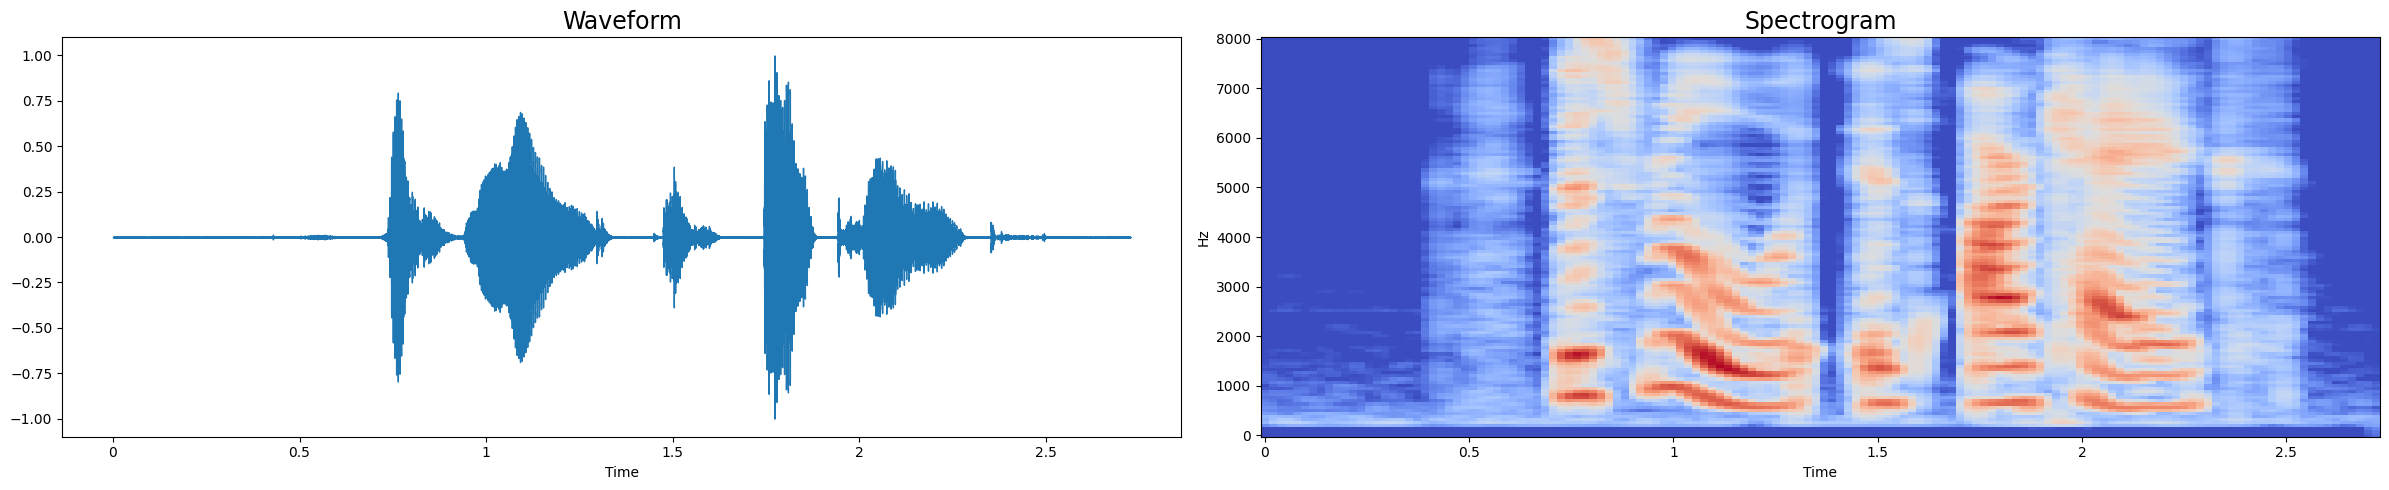

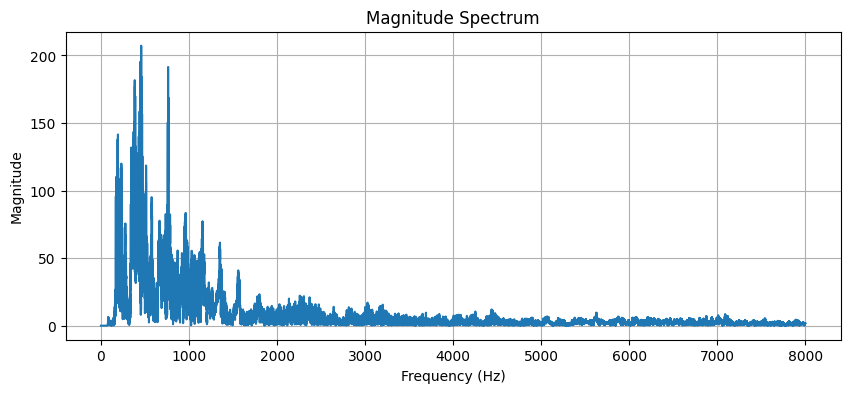

In [37]:
row = train_df[train_df.target==0].iloc[20]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec)
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
get_magnitude_spec(audio, sr=16000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')
plt.grid(True)
plt.show()


### spoof

> Filename: LA_T_1780590 | Label: spoof
# Listen


# Plot



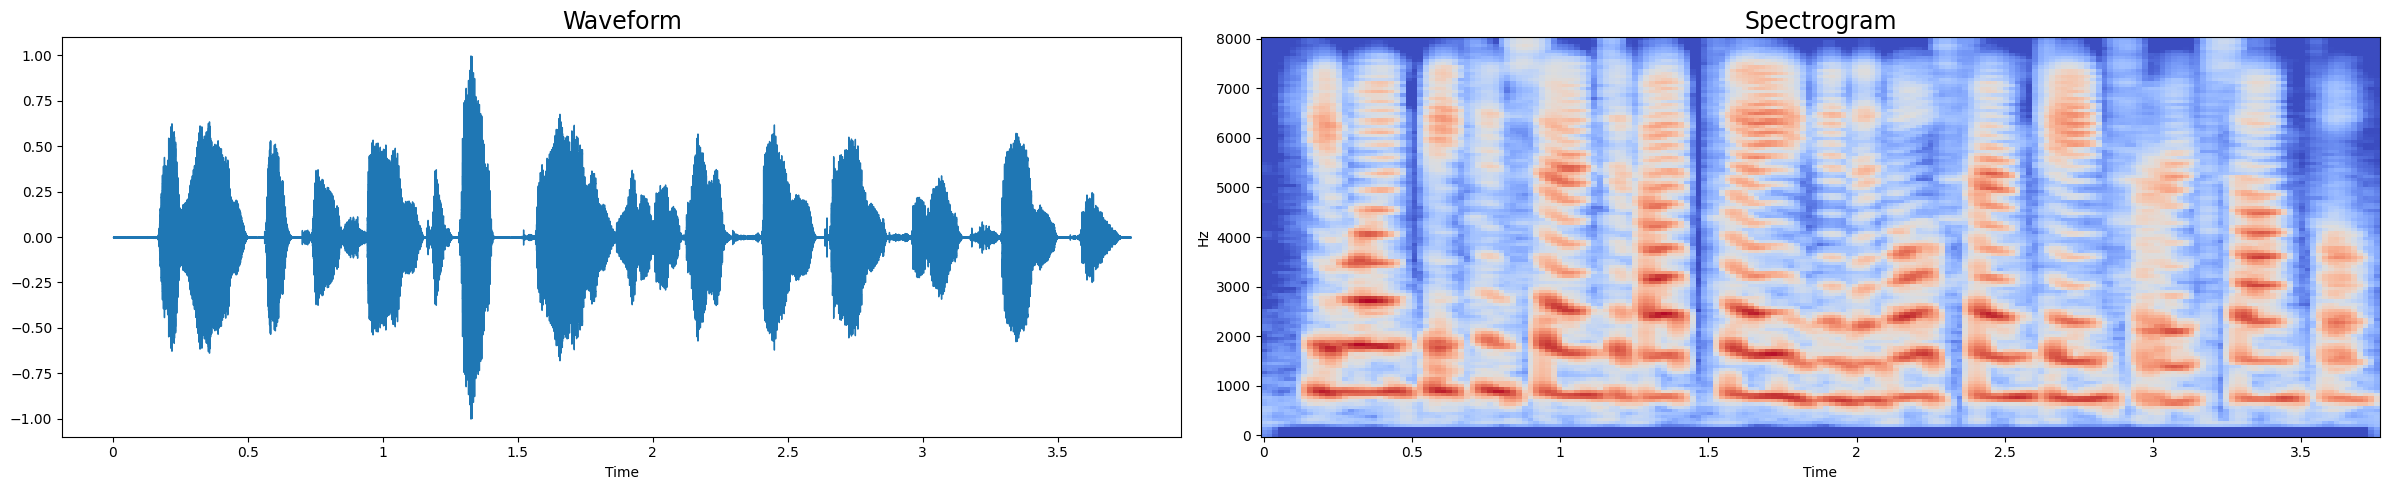

In [14]:
row = train_df[train_df.target==1].iloc[10]
print(f'> Filename: {row.filename} | Label: {row.class_name}')
audio, sr= load_audio(row.filepath, sr=None)
audio = audio[:AUDIO_LEN]
spec = get_spec(audio)

print('# Listen')
listen_audio(audio, sr=16000)

print("# Plot\n")
plt.figure(figsize=(12*2,5))

plt.subplot(121)
plot_audio(audio)
plt.title("Waveform",fontsize=17)

plt.subplot(122)
plot_spec(spec)
plt.title("Spectrogram",fontsize=17)

plt.tight_layout()
plt.show()

選取聲音到資料集，試圖一半一半

In [16]:
import os
import shutil

# Source and destination folders
source_folder = "spectrogram_images_train"
destination_folder = "spectrogram_images_train_part1"

# Ensure the destination folder exists, create if not
os.makedirs(destination_folder, exist_ok=True)

fake = 500
real = 500
# Iterate through files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".png"):  # Adjust the file extension as needed
        if train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 1 and fake < 500:
            fake += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
        elif train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 0 and real < 500:
            real += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
        
        if real == 500 and fake == 500:
            break 


再找其他資料當作測試集

In [17]:
import os
import shutil

# Source and destination folders
source_folder = "spectrogram_images_train"
destination_folder = "spectrogram_images_train_for_test_part1"

# Ensure the destination folder exists, create if not
os.makedirs(destination_folder, exist_ok=True)

fake = 0
real = 0
# Iterate through files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".png"):  # Adjust the file extension as needed
        if train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 1 and fake < 1000:
            fake += 1
            continue
        elif train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 0 and real < 1000:
            real += 1
            continue
        
        if train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 1 and fake < 1000:
            fake += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
        elif train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 0 and real < 1000:
            real += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
        
        if real == 1000 and fake == 1000:
            break


抓clean data

In [17]:
import os
import shutil

# Source and destination folders
source_folder = "clean_spectrogram_images_train"
destination_folder1 = "clean_spectrogram_images_train_part1"
destination_folder2 = "clean_spectrogram_images_train_part1"

# Ensure the destination folder exists, create if not
os.makedirs(destination_folder1, exist_ok=True)
os.makedirs("clean_spectrogram_images_train_for_test", exist_ok=True)

fake = 0
real = 0
thre = 500
b = True
b2 = True

# Iterate through files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".png"):  # Adjust the file extension as needed
        if b and train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 1 and fake < thre:
            fake += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder1, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
            if fake == thre:
                destination_folder1 = "clean_spectrogram_images_train_for_test"
                b = False
                fake = 0

        elif b2 and train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 0 and real < thre:
            real += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder2, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
            if real == thre:
                destination_folder2 = "clean_spectrogram_images_train_for_test"
                b2 = False
                real = 0
        ##################################################################################
        if (not b) and train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 1 and fake < thre:
            fake += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder1, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
        elif (not b2) and train_df[train_df['filename'] == filename[5:-4]]["target"].values[0] == 0 and real < thre:
            real += 1
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder2, filename)

            # Copy the file to the destination folder instead of moving
            shutil.copy(source_path, destination_path)
        

        if real == thre and fake == thre:
            break 
